In [1]:
from dataset.dataset import test_train_split, get_meta_gloss_dataloader, SignGlossDataset
import random
import numpy as np
import os
import torch

from model.gaussian_noise import GaussianNoise
from torchvision import transforms


seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
generator = torch.Generator()
generator.manual_seed(seed)

transform = transforms.Compose([GaussianNoise(0, 0.001)])
interp_transform = transforms.Compose([GaussianNoise(0, 0.005)])
dataset = SignGlossDataset(transform=transform, max_pad_len=300)

Loading dataset: 100%|██████████| 21080/21080 [00:03<00:00, 5447.47it/s]

Number of classes: 2000
Total dataset length: 21080
Longest sample: 247 frames long, shortest sample: 9 frames long


In [2]:
train_dataset, test_dataset = test_train_split(dataset)

In [3]:
train_dataloader = get_meta_gloss_dataloader(train_dataset, interpolation_transform=interp_transform)
test_dataloader = get_meta_gloss_dataloader(test_dataset, interpolation_transform=interp_transform)

In [4]:
l_support, r_support, b_support, support_labels, l_query, r_query, b_query, query_labels = next(iter(train_dataloader))

In [5]:
print(l_support.shape, r_support.shape, b_support.shape, support_labels.shape, l_query.shape, r_query.shape, b_query.shape)

torch.Size([30, 300, 21, 3]) torch.Size([30, 300, 21, 3]) torch.Size([30, 300, 7, 3]) torch.Size([30]) torch.Size([41, 300, 21, 3]) torch.Size([41, 300, 21, 3]) torch.Size([41, 300, 7, 3])


In [6]:
print(query_labels)

tensor([[9, 4, 6],
        [4, 6, 8],
        [4, 6, 8],
        [6, 8, 6],
        [8, 6, 0],
        [8, 6, 0],
        [6, 0, 7],
        [6, 0, 7],
        [0, 7, 6],
        [7, 6, 5],
        [6, 5, 1],
        [6, 5, 1],
        [6, 5, 1],
        [5, 1, 9],
        [1, 9, 3],
        [1, 9, 3],
        [9, 3, 3],
        [9, 3, 3],
        [3, 3, 0],
        [3, 0, 9],
        [3, 0, 9],
        [0, 9, 1],
        [9, 1, 5],
        [9, 1, 5],
        [1, 5, 4],
        [5, 4, 7],
        [4, 7, 8],
        [7, 8, 3],
        [8, 3, 0],
        [8, 3, 0],
        [3, 0, 1],
        [3, 0, 1],
        [0, 1, 7],
        [1, 7, 2],
        [1, 7, 2],
        [7, 2, 5],
        [2, 5, 2],
        [2, 5, 2],
        [5, 2, 4],
        [5, 2, 4],
        [2, 4, 8]])


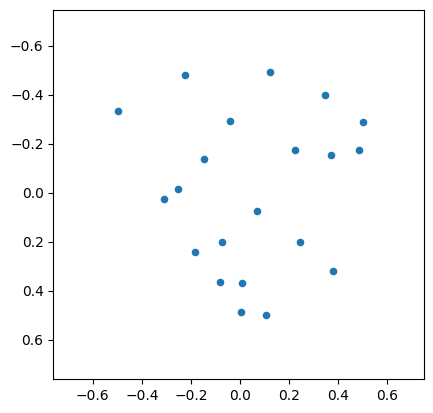

In [7]:
from preprocess.visualize import render
from IPython.display import HTML

anim = render(l_query[0])
HTML(anim.to_jshtml())


In [43]:
l_support, r_support, b_support, support_labels, l_query, r_query, b_query, query_labels = [d.to('cuda') for d in next(iter(test_dataloader))]

In [5]:
import torch
from model.model import SiFormerMeta, MetaLearning

device = 'cuda'
backbone = SiFormerMeta(emb_dim=128, seq_len=300, max_class_per_input=3)
model = MetaLearning(backbone).to(device)
state_dict = torch.load("checkpoints/330_0.7103646683772646")
model.load_state_dict(state_dict, strict=False)


Feature isolated transformer
self.selected_attn prob
Encoder with input adaptive
self.selected_attn prob
Encoder with input adaptive
self.selected_attn prob
Encoder with input adaptive
Using custom DecoderLayer
Normal decoder
num_enc_layers 3, num_dec_layers 2, patient 1


c:\Users\kneep\Desktop\Handy 2.0\MetaSign\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


_IncompatibleKeys(missing_keys=[], unexpected_keys=['dist_threshold'])

In [49]:
from collections import defaultdict


model.eval()

total = 0
correct_per_words = torch.tensor([0, 0, 0], device=device)

K = l_query.shape[0]
logits = model(l_support, r_support, b_support, l_query, r_query, b_query)
preds = torch.argmax(logits, dim=1)
answer = (preds == query_labels.view(-1)).view(K, -1)
answer = torch.sum(answer, dim=0)
correct_per_words += answer
total += K


In [50]:
correct_per_words/total

tensor([0.6957, 0.6522, 0.6087], device='cuda:0')

In [51]:
correct_per_label = defaultdict(int)
total_per_label = defaultdict(int)

true_labels = support_labels.view(-1, 3)[:, 0]
ql_to_true_labels = {i: v.item() for i, v in enumerate(true_labels)}
ql_to_true_labels[10] = -1
for query_label, pred in zip(query_labels.view(-1), preds):
    correct_per_label[ql_to_true_labels[query_label.item()]] += int(pred == query_label)
    total_per_label[ql_to_true_labels[query_label.item()]] += 1

accuracy_per_label = defaultdict(int)
for (idx, correct), total in zip(correct_per_label.items(), total_per_label.values()):
    accuracy_per_label[idx] = correct/total

print(accuracy_per_label)

defaultdict(<class 'int'>, {729: 0.7692307692307693, 183: 0.14285714285714285, 1115: 0.5555555555555556, 1474: 1.0, 800: 0.5, 426: 0.7692307692307693, 1616: 0.7692307692307693, 1447: 0.5555555555555556, -1: 0.0, 879: 1.0, 1749: 0.7058823529411765})


In [52]:
from sklearn.metrics import confusion_matrix

# Example tensors

# Convert to NumPy
labels_np = query_labels.view(-1).cpu().numpy()
preds_np = preds.cpu().numpy()
print(labels_np.shape, preds_np.shape)
# Get confusion matrix
cm = confusion_matrix(labels_np, preds_np)
print(cm)


(138,) (138,)
[[ 5  0  1  0  0  0  0  0  3  0  0]
 [ 0 10  0  0  0  0  1  1  0  1  0]
 [ 0  0 15  0  0  0  0  0  0  0  0]
 [ 2  0  1 12  0  0  0  2  0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0  0]
 [ 0  3  0  0  0  2  0  0  0  9  0]
 [ 0  0  0  0  2  1  8  3  1  1  0]
 [ 0  0  1  0  1  2  4 10  0  0  0]
 [ 0  0  0  0  0  0  1  1 10  1  0]
 [ 0  0  0  0  0  2  0  0  0 10  1]
 [ 0  0  0  0  0  0  0  2  0  0  0]]
